# Linear Additive Phenotype Simulation Example

Many phenotype simulation tools and GWAS models assume a linear additive genetic architecture. This notebook demonstrates how to simulate a phenotype with a linear additive genetic architecture using CITRUS.

The Python API is used to configure and run the simulation in this notebook. The simulation could be run from the command line using the `citrus simulate` command with a config JSON file matching the config dict in this example. See the [Command Line Interface](../cli.md) documentation for more information.

## Linear Additive Genetic Architecture

A linear additive genetic architecture is one where the phenotype is the sum of the effects of each variant. The phenotype is modeled as:

$$
\begin{align}
y = \sum_{i=1}^{n} \beta_i x_i + \epsilon
\end{align}
$$

where $y$ is the phenotype, $n$ is the number of variants, $\beta_i$ is the effect size of variant $i$, $x_i$ is the genotype of variant $i$, and $\epsilon$ is the error term.






# Designing the Simulation

The three main components of this archetecture that require descisions are the input variants ($x_i$), the effect sizes ($\beta_i$), and the error term ($\epsilon$).

## Input Variants

These will be the SNPs that actually impact the phenotype. In the equation above, $x_i$ will be 0 if the SNP is the reference allele and 1 if it is any alternate allele. When actually running the simulation, we will get these values from a VCF file from 1000 Genomes.

For this example I found input SNPs on chromosome 19 using the [NIH Library of Medicine website](https://www.ncbi.nlm.nih.gov/snp). Below is a table of the rsIDs, loci (GRCh37), and minor allele frequencies (MAF) of the input SNPs.

| rsID      | Locus     | MAF   |
|-----------|-----------|-------|
|rs16029|19:13397324|0.01|
|rs2145404651|19:52901080|0.01|
|rs2145329733|19:16023111|0.02|
|rs4029|19:55555845|0.08|
|rs1555916387|19:55261043|0.16|
|rs238414|19:45857820|0.42|
|rs269952|19:55442280|0.43|
|rs2015|19:39369369|0.48|

## Effect Sizes

The effect sizes will be the $\beta_i$ values in the equation above.

Rarer variants often have larger effect sizes. To model that in this simulation, input variants are split into two groups: rare (1-2% MAF) and common. Both groups will then draw betas from mean 0 normal distributions, but the rare variants will draw from a distribution with a greater variance. The rare group will have a standard deviation of 0.5 and the common group will have a standard deviation of 0.2.

## Noise

There are two ways to model the noise term. The first is to draw a noise value from some normal distribution and add it to the phenotype. The challenge with this approach is choosing a standard disrtibution of the noise distribution that will give you the proper ratio of genetic signal to noise.

The second approach is to use the [Heritability](../operator_nodes/noise.md#class-heritability) operator node. This node allows you to set a heritability value and then returns a weighted average of the input signal and sampled noise that will give you the desired heritability. This approach is used in this example.

# Configuring the Simulation

To run a simulation we have to define it as configuration dict (or JSON file with the command line interface). The simulation configuration has two keys: 'input' and 'simulation_steps'. The 'input' key defines the input variants and the 'simulation_steps' key defines the steps of the simulation.

## Input Configuration

In this simulation there is a single input source file which generates the values for all the input nodes. The value for the 'input' key is a list of dicts defining input sources. Here, it will be a list with a single dict defining that source file and input nodes.

The input nodes are all of the [SNP type](../input_nodes.md#single-nucleotide-polymorphisms-snps-snp). For more information on [input nodes](../input_nodes.md) and [input sources](../input_sources.md), see the linked documentation. 

In [1]:
config_dict = {
	"input": [
		{
			"file": "1000_genomes_data/ALL.chr19.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz",
			"file_format": "vcf",
			"reference_genome": "GRCh37",
			"force_bgz": True,
			"input_nodes": [
				{
					"alias": "rare_variants",
					"type": "SNP",
					"chr": "19",
					"pos": [13397324, 52901080, 16023111]
				},
				{
					"alias": "common_variants",
					"type": "SNP",
					"chr": "19",
					"pos": [55555845, 55261043, 45857820, 55442280, 39369369]
				}
			]
		}
	]
}

## Simulation Steps Configuration

This simulation requires 8 operator nodes:

- 2 [RandomConstant](../operator_nodes/constant_func.md#class-randomconstant) nodes to draw the effect sizes for the rare and common variants.
- 2 [Product](../operator_nodes/math_func.md#class-product) nodes to multiply the effect sizes by the input genotypes to get the effect values.
- 1 [Concatenate](../operator_nodes/util_func.md#class-concatenate) node to combine the rare and common variant effect values.
- 1 [AdditiveCombine](../operator_nodes/hap_combine_func.md#class-additivecombine) node to sum the effect values of both haplotypes.
- 1 [SumReduce](../operator_nodes/reduce_func.md#class-sumreduce) node to sum the effect values of all variants into a single value per individual.
- 1 [Heritability](../operator_nodes/noise.md#class-heritability) node to add noise to the phenotype to achieve the desired heritability.

When defining these in the config dict, the order of the nodes is important, as the nodes are defined in the order they are executed. An order will always be valid if the input for a node is an input node or an operator node defined earlier in the list.

In [2]:
config_dict["simulation_steps"] = [
	{
		"type": "RandomConstant",
		"alias": "rare_variants_betas",
		"input_match_size": "rare_variants",
		"dist_name": "normal",
		"dist_kwargs": {
			"loc": 0.0,
			"scale": 0.5
		},
		"by_feat": True
	},
	{
		"type": "RandomConstant",
		"alias": "common_variants_betas",
		"input_match_size": "common_variants",
		"dist_name": "normal",
		"dist_kwargs": {
			"loc": 0.0,
			"scale": 0.2
		},
		"by_feat": True
	},
	{
		"type": "Product",
		"alias": "rare_variant_effects",
		"input_aliases": [
			"rare_variants_betas", "rare_variants"
		]
	},
	{
		"type": "Product",
		"alias": "common_variant_effects",
		"input_aliases": [
			"common_variants_betas", "common_variants"
		]
	},
	{
        "type": "Concatenate",
        "alias": "variant_effects",
        "input_aliases": [
            "rare_variant_effects", "common_variant_effects"
		],
	},
	{
		"type": "AdditiveCombine",
		"alias": "combined_variant_effects",
		"input_alias": "variant_effects"
	},
	{
        "type": "SumReduce",
        "alias": "no_noise_phenotype",
        "input_alias": "combined_variant_effects"
	},
	{
		"type": "Heritability",
        "alias": "phenotype",
        "input_alias": "no_noise_phenotype",
        "heritability": 0.8
	}
]

## Complete Configuration

The configuration is also saved to the json_configs directory for use with the command line interface.

In [3]:
import json
import os
from pprint import pprint

# Save config_dict to a JSON file
with open(os.path.join("json_configs", "linear_additive_pheno.json") , "w") as f:
	json.dump(config_dict, f, indent=4)

# Print config_dict
pprint(config_dict, indent=2, depth=6, sort_dicts=False)

{ 'input': [ { 'file': '1000_genomes_data/ALL.chr19.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz',
               'file_format': 'vcf',
               'reference_genome': 'GRCh37',
               'force_bgz': True,
               'input_nodes': [ { 'alias': 'rare_variants',
                                  'type': 'SNP',
                                  'chr': '19',
                                  'pos': [13397324, 52901080, 16023111]},
                                { 'alias': 'common_variants',
                                  'type': 'SNP',
                                  'chr': '19',
                                  'pos': [ 55555845,
                                           55261043,
                                           45857820,
                                           55442280,
                                           39369369]}]}],
  'simulation_steps': [ { 'type': 'RandomConstant',
                          'alias': 'rare_variants_betas

# Running the Simulation

In [4]:
from pheno_sim import PhenoSimulation

/Users/ross/Desktop/gwas/CITRUS/pheno_sim/heritability_estimation/herit_est.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [5]:
# Create simulation
sim = PhenoSimulation(config_dict)

# Run simulation
sim_vals = sim.run_simulation()

Initializing Hail with default parameters...


Loading input data...


SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.
SLF4J: Class path contains SLF4J bindings targeting slf4j-api versions 1.7.x or earlier.
SLF4J: Ignoring binding found at [jar:file:/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See https://www.slf4j.org/codes.html#ignoredBindings for an explanation.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.2
SparkUI available at http://desktop-oj0d0vr.localdomain:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.118-a4ca239602bb
LOGGING: writing to /Users/ross/Desktop/gwas/CITRUS/doc/example_nbs/hail-20230814-1337-0.2.118-a4ca239602bb.l

In [6]:
sim_vals.keys()

dict_keys(['rare_variants', 'common_variants', 'rare_variants_betas', 'common_variants_betas', 'rare_variant_effects', 'common_variant_effects', 'variant_effects', 'combined_variant_effects', 'no_noise_phenotype', 'phenotype'])

# Visualizing the Simulated Phenotype

First we can convert some of the simulation output to a dataframe and plot the overall distribution of the phenotype.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
pheno_df = pd.DataFrame({
	"no_noise_phenotype": sim_vals["no_noise_phenotype"].astype(float),
    "phenotype": sim_vals["phenotype"].astype(float),
    "sample_ids": sim.sample_ids,
})

Text(0.5, 1.0, 'Phenotype Distribution')

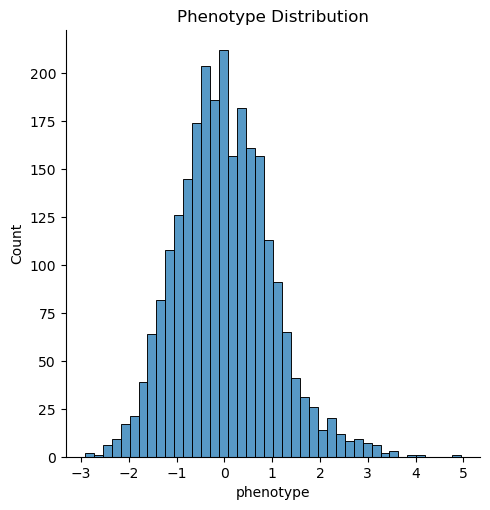

In [9]:
sns.displot(
	data=pheno_df,
	x="phenotype",
)
plt.title("Phenotype Distribution")

We can compare this to the phenotype distribution before the noise was added to achieve the desired heritability.

Text(0.5, 1.0, 'Phenotype Distribution (with and without noise)')

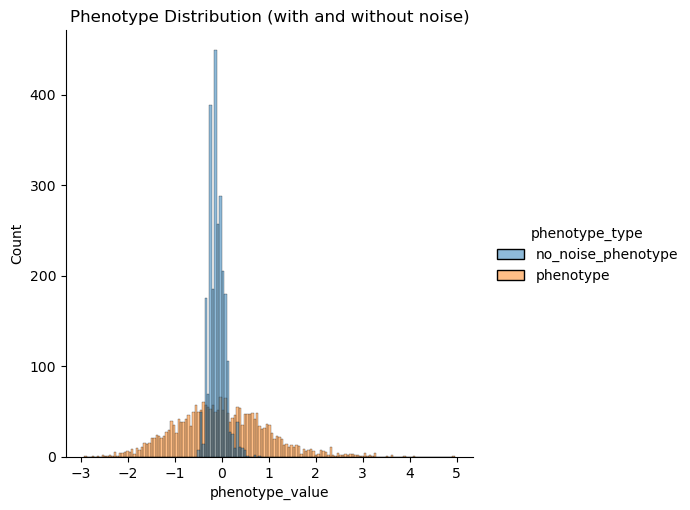

In [10]:
melted_df = pheno_df.melt(
	id_vars="sample_ids",
	value_vars=["no_noise_phenotype", "phenotype"],
	var_name="phenotype_type",
	value_name="phenotype_value",
)

sns.displot(
	data=melted_df,
	x="phenotype_value",
	hue="phenotype_type",
)
plt.title("Phenotype Distribution (with and without noise)")

We can color the final phenotypes by their quintile before noise was added to see how the noise affects the phenotype distribution.

In [11]:
# Add quintile column based on no_noise_phenotype
pheno_df["quintile_without_noise"] = pd.qcut(
	pheno_df["no_noise_phenotype"],
	q=5,
	labels=["1", "2", "3", "4", "5"],
)

Text(0.5, 1.0, 'Phenotype Distribution by Pre-Noise Quintile')

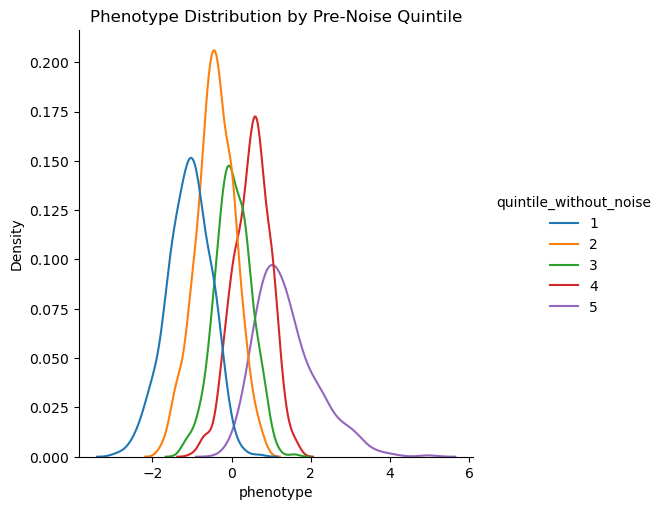

In [12]:
sns.displot(
	data=pheno_df,
	x="phenotype",
	hue="quintile_without_noise",
    kind="kde",
)
plt.title("Phenotype Distribution by Pre-Noise Quintile")

# Estimating Heritability of Phenotype

Finally, we can estimate the narrow- and broad-sense heritability of our simulated phenotype. With a linear additive phenotype these values should be the same.

In [13]:
from pheno_sim.heritability_estimation import (
    narrow_sense_heritability,
    broad_sense_heritability
)

In [14]:
input_vals = sim.run_input_step()

Loading input data...


2023-08-14 13:43:10.237 Hail: INFO: wrote matrix table with 8 rows and 2504 columns in 3 partitions to /tmp/persist_MatrixTableHnpy8PXZOv


In [15]:
narrow_sense_heritability(
	sim,
	input_vals=input_vals,
	confidence_level=0.95,
)

100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


{'h2': 0.7984997842243964,
 'h2_ci_lower': 0.7918479593000338,
 'h2_ci_upper': 0.8046562184430114}

In [16]:
broad_sense_heritability(
    sim,
    input_vals=input_vals,
	confidence_level=0.95,
)

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


{'H2': 0.8007193046580234,
 'H2_ci_lower': 0.8005174528280001,
 'H2_ci_upper': 0.8009360620867733}